In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import matplotlib
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

import os
from tqdm import tqdm

import dask.dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count
nCores = cpu_count()

from dask.diagnostics import ProgressBar
ProgressBar().register()

In [2]:
matplotlib.rcParams['figure.figsize'] = (13, 8)

In [3]:
# create datetime object
def time_fixer(data):
    datetime_real = (datetime(int(data.loc['Year']), int(data.loc['Month']), int(data.loc['Day']), hour=int(data.loc['Hour']), minute=int(data.loc['Minute'])))

    return datetime_real

In [4]:
directory = os.getcwd() + '/asset/'
header = pd.read_csv('header.csv').columns
data = pd.DataFrame()
csv_list = [directory + '/' + z for z in os.listdir(directory)]

# Concat's .csv's
for x in tqdm(csv_list):
    csv = pd.read_csv(x, header=None)
    csv.columns = header
    data = pd.concat([data, csv], axis=0)

# Resets index.
data.reset_index(drop=True, inplace=True) 

# Dask apply.
data['datetime'] = dd.from_pandas(data, npartitions = nCores).\
                    map_partitions(
                    lambda data_mini : data_mini.apply(
                    lambda x: time_fixer(x), axis=1)).compute()

data.set_index('datetime', inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.55it/s]


[########################################] | 100% Completed | 9.65 ss


In [5]:
data.shape

(105120, 23)

In [6]:
data.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,Fill Flag,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,2017,1,1,0,0,15.7,0,0,0,0,...,0,0,0.241,60.66,166.30,0.05,821,1.4,340,3.2
2017-01-01 00:15:00,2017,1,1,0,15,15.6,0,0,0,0,...,0,0,0.241,61.05,168.07,0.05,821,1.4,341,3.2
2017-01-01 00:30:00,2017,1,1,0,30,15.5,0,0,0,0,...,0,0,0.241,61.44,168.94,0.05,821,1.4,341,3.2
2017-01-01 00:45:00,2017,1,1,0,45,15.4,0,0,0,0,...,0,0,0.241,60.86,168.69,0.05,821,1.4,342,3.1
2017-01-01 01:00:00,2017,1,1,1,0,15.4,0,0,0,0,...,0,0,0.241,60.78,167.40,0.05,820,1.4,342,3.1


In [7]:
# drop redundant and unnecessary features
data.drop(['Year', 'Month', 'Day', 'Hour','Minute', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'DHI', 'DNI'], axis=1, inplace=True)

In [8]:
data.head()

,Temperature,Cloud Type,Dew Point,Fill Flag,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
datetime,,,,,,,,,,,,,
2017-01-01 00:00:00,15.7,0,8.1,0,0,0.241,60.66,166.30,0.05,821,1.4,340,3.2
2017-01-01 00:15:00,15.6,0,8.1,0,0,0.241,61.05,168.07,0.05,821,1.4,341,3.2
2017-01-01 00:30:00,15.5,0,8.1,0,0,0.241,61.44,168.94,0.05,821,1.4,341,3.2
2017-01-01 00:45:00,15.4,0,7.9,0,0,0.241,60.86,168.69,0.05,821,1.4,342,3.1
2017-01-01 01:00:00,15.4,0,7.9,0,0,0.241,60.78,167.40,0.05,820,1.4,342,3.1


In [9]:
data = data.resample('15T').mean()

In [10]:
data.sort_index(inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105120 entries, 2017-01-01 00:00:00 to 2019-12-31 23:45:00
Freq: 15T
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Temperature         105120 non-null  float64
 1   Cloud Type          105120 non-null  float64
 2   Dew Point           105120 non-null  float64
 3   Fill Flag           105120 non-null  float64
 4   GHI                 105120 non-null  float64
 5   Ozone               105120 non-null  float64
 6   Relative Humidity   105120 non-null  float64
 7   Solar Zenith Angle  105120 non-null  float64
 8   Surface Albedo      105120 non-null  float64
 9   Pressure            105120 non-null  float64
 10  Precipitable Water  105120 non-null  float64
 11  Wind Direction      105120 non-null  float64
 12  Wind Speed          105120 non-null  float64
dtypes: float64(13)
memory usage: 11.2 MB


In [12]:
# Prints column/number of negative values
for x in data.columns:
    print(x, len(data[data[x] < 0]))

Temperature 0
Cloud Type 0
Dew Point 1429
Fill Flag 0
GHI 0
Ozone 0
Relative Humidity 0
Solar Zenith Angle 0
Surface Albedo 0
Pressure 0
Precipitable Water 0
Wind Direction 0
Wind Speed 0


In [13]:
for y in data.columns:
    data[y].replace([x for x in data[y] if x <= -999], np.nan, inplace=True)

In [14]:
df=data.copy()

In [27]:
len(df[df['Fill Flag'] != 0]['GHI'])

7648

In [22]:
df=data[data.index.hour < 19]
len(df)

83220

In [25]:
df= df[df.index.hour > 5]
len(df)

56940

In [26]:
df

,Temperature,Cloud Type,Dew Point,Fill Flag,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
datetime,,,,,,,,,,,,,
2017-01-01 06:00:00,11.8,0.0,0.5,0.0,0.0,0.242,45.71,102.49,0.05,821.0,0.4,115.0,5.6
2017-01-01 06:15:00,12.2,0.0,0.5,0.0,0.0,0.242,44.52,99.07,0.05,821.0,0.4,115.0,5.7
2017-01-01 06:30:00,12.6,0.0,0.5,0.0,0.0,0.242,43.37,95.67,0.05,821.0,0.4,115.0,5.8
2017-01-01 06:45:00,12.9,0.0,0.4,0.0,0.0,0.241,42.35,92.29,0.05,821.0,0.4,115.0,5.9
2017-01-01 07:00:00,13.3,0.0,0.4,0.0,18.0,0.241,41.32,88.64,0.05,822.0,0.4,115.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 17:45:00,22.6,0.0,10.8,0.0,77.0,0.234,47.20,83.65,0.05,820.0,2.0,295.0,4.7
2019-12-31 18:00:00,22.0,0.0,10.8,0.0,32.0,0.234,48.95,86.91,0.05,820.0,2.0,296.0,4.8
2019-12-31 18:15:00,21.6,0.0,10.8,0.0,0.0,0.234,50.22,90.01,0.05,821.0,2.0,298.0,5.0


In [28]:
for i, x in enumerate(df['Fill Flag']):
    if x != 0:
        df['GHI'][i]=np.nan

In [29]:
df.isnull().sum()

Temperature              0
Cloud Type               0
Dew Point                0
Fill Flag                0
GHI                   7648
Ozone                    0
Relative Humidity        0
Solar Zenith Angle       0
Surface Albedo           0
Pressure                 0
Precipitable Water       0
Wind Direction           0
Wind Speed               0
dtype: int64

In [ ]:
df['linear']=df['GHI'].interpolate(method='linear')
df['spline']=df['GHI'].interpolate(method='spline', order=3)
df['time']=df['GHI'].interpolate(method='time')
df['ffill']=df['GHI'].ffill()
df['bfill']=df['GHI'].bfill()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
ffill=r2_score(data[df['GHI'].isna()]['GHI'], df[df['GHI'].isna()]['ffill'])
bfill=r2_score(data[df['GHI'].isna()]['GHI'], df[df['GHI'].isna()]['bfill'])
spline=r2_score(data[df['GHI'].isna()]['GHI'], df[df['GHI'].isna()]['spline'])
linear=r2_score(data[df['GHI'].isna()]['GHI'], df[df['GHI'].isna()]['linear'])
time=r2_score(data[df['GHI'].isna()]['GHI'], df[df['GHI'].isna()]['time'])
print(ffill,bfill,spline,linear,time)

In [ ]:
df.drop(['ffill', 'bfill', 'spline', 'linear','time'], axis=1, inplace=True)

In [30]:
for x in df.columns:
    df[x].interpolate(method='linear', inplace=True)

In [33]:
# Check nulls.
df.isnull().sum()

Temperature           0
Cloud Type            0
Dew Point             0
Fill Flag             0
GHI                   0
Ozone                 0
Relative Humidity     0
Solar Zenith Angle    0
Surface Albedo        0
Pressure              0
Precipitable Water    0
Wind Direction        0
Wind Speed            0
dtype: int64

In [34]:
# detect outlier
round(df.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
Temperature,56940.0,23.47,3.58,11.20,20.90,23.50,26.00,33.40
Cloud Type,56940.0,2.13,2.68,0.00,0.00,0.00,4.00,9.00
Dew Point,56940.0,11.19,4.78,-8.30,8.00,12.30,15.20,19.10
Fill Flag,56940.0,0.37,0.98,0.00,0.00,0.00,0.00,5.00
GHI,56940.0,460.77,349.80,0.00,100.00,461.00,780.00,1110.00
Ozone,56940.0,0.26,0.01,0.22,0.24,0.26,0.27,0.28
Relative Humidity,56940.0,50.55,20.77,9.28,32.39,49.47,67.48,95.84
Solar Zenith Angle,56940.0,52.82,25.20,0.09,33.10,51.82,73.96,103.99
Surface Albedo,56940.0,0.06,0.01,0.04,0.05,0.06,0.07,0.10
Pressure,56940.0,820.35,1.43,815.00,819.00,820.00,821.00,825.00


In [ ]:
# outlier detection
df['GHI'].replace([x for x in df['GHI'] if x >= 2000], np.nan, inplace=True)

In [556]:
df['GHI'].interpolate(method='linear', inplace=True)

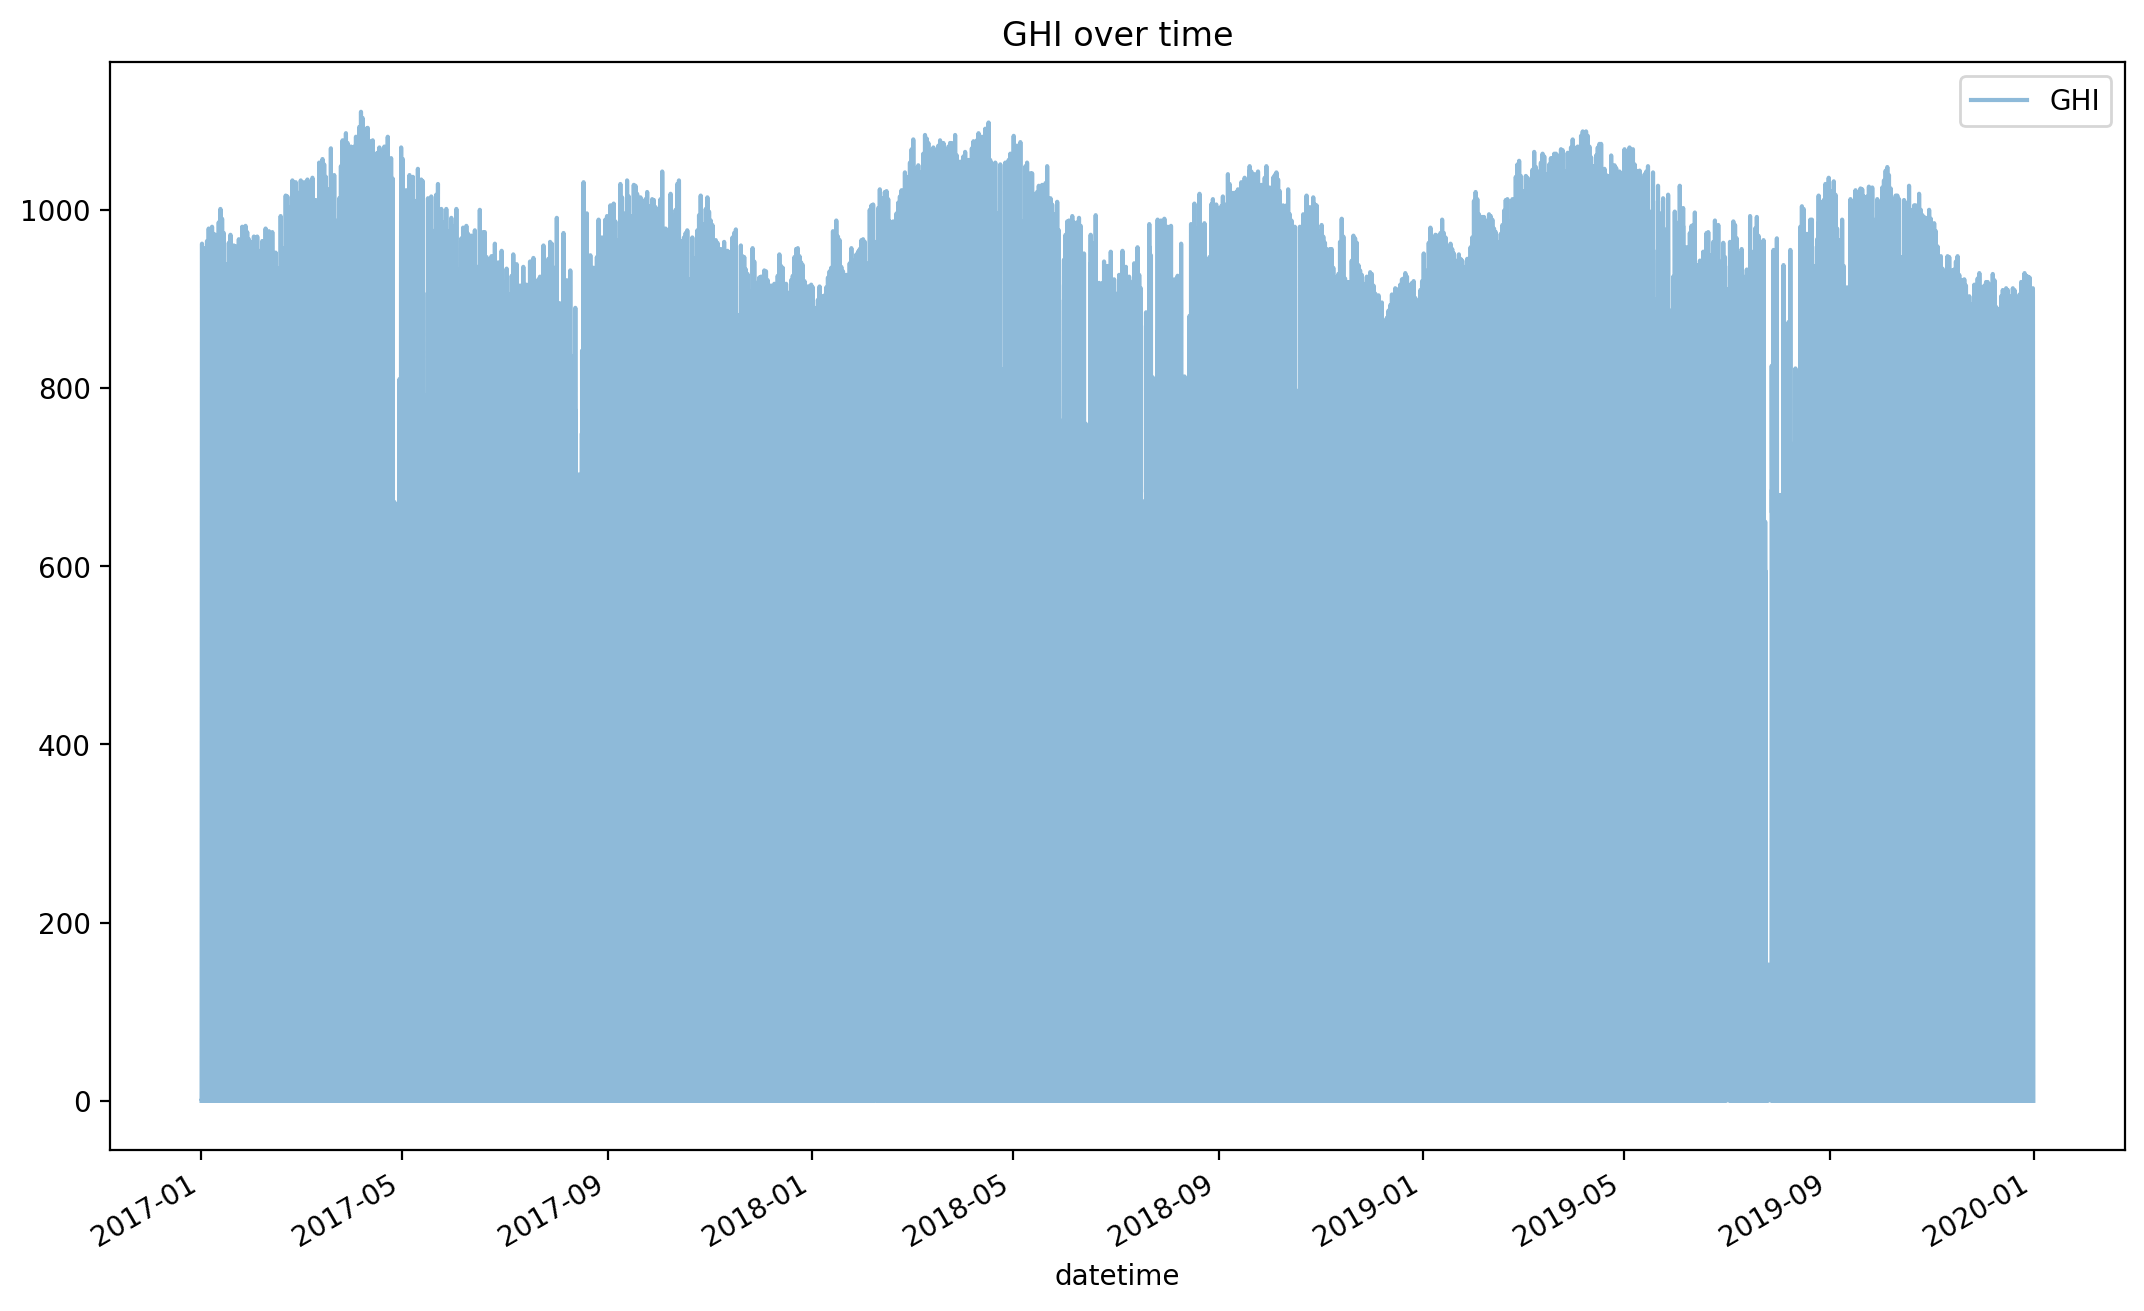

In [35]:
# Irradiance metrics over time
df[['GHI']].plot(alpha=.5)
plt.title('GHI over time');

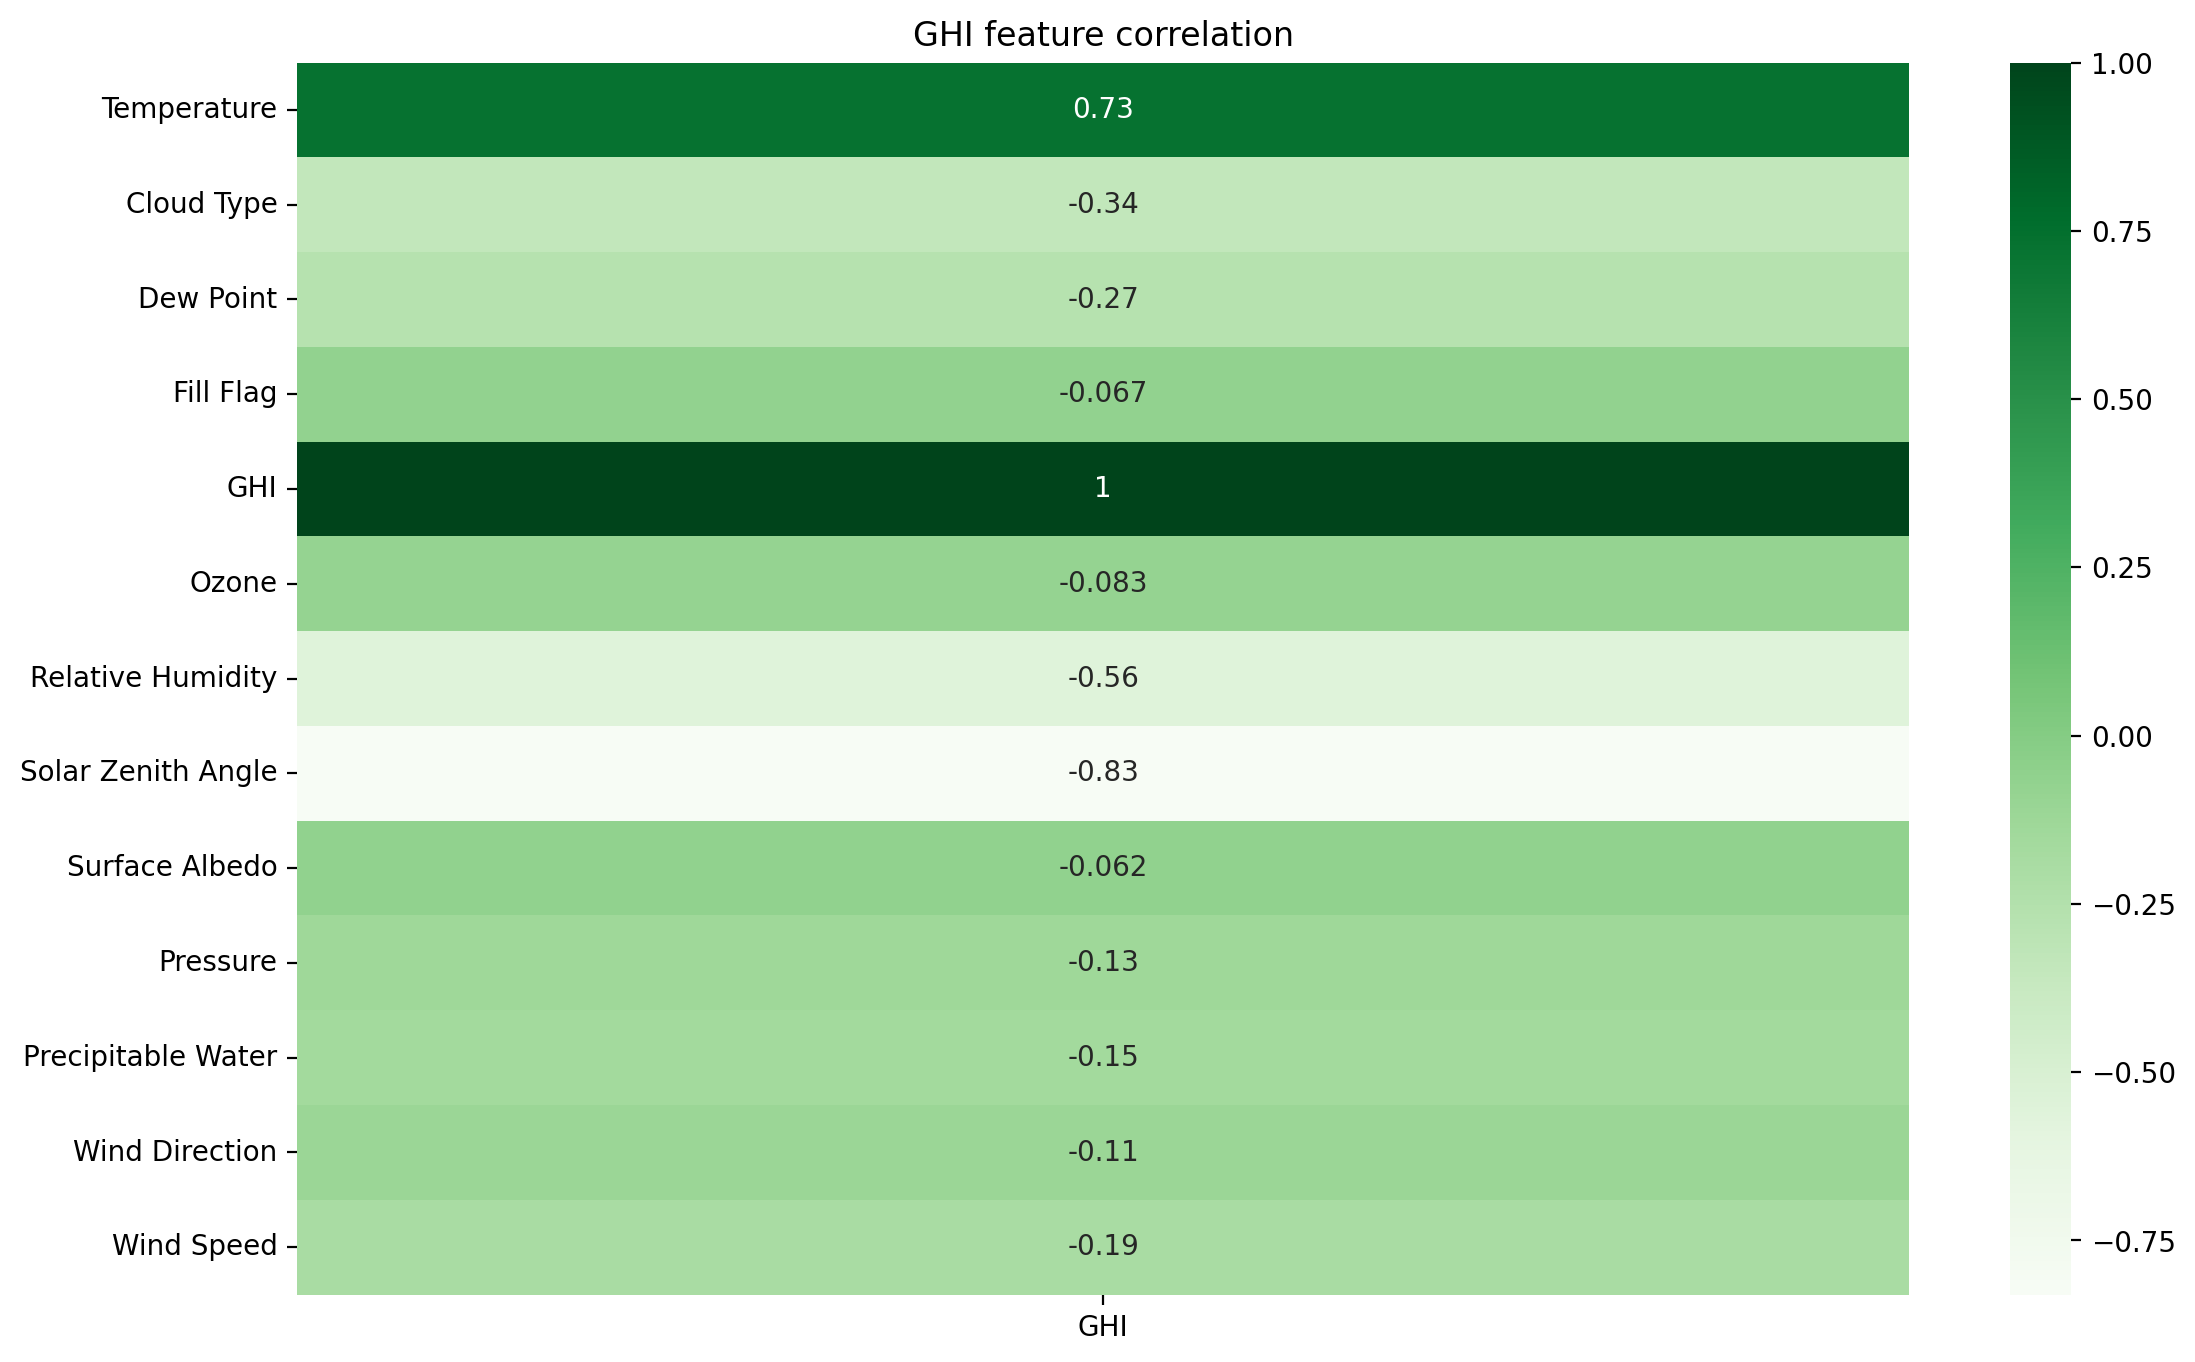

In [38]:
# Feature correlation for irradiance metrics
sns.heatmap(data.corr()[['GHI']], cmap='Greens', annot=True)
plt.title('GHI feature correlation');

In [39]:
data.to_pickle('./pickle.pkl')